In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
from fastai.vision import *
from fastai.metrics import error_rate

In [3]:
import scipy.io
import pandas as pd

In [4]:
import warnings
warnings.filterwarnings('once')

To have reproducible result, we will seed everything

In [5]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [6]:
bs = 64

In [7]:
data = scipy.io.loadmat('data/cars_annos.mat')
classes = {i:data['class_names'][0][i][0] for i in range(data['class_names'].shape[1])}
data = data['annotations'][0]

# target =[data[i][-2][0][0] for i in range(data.shape[0])]
# image_id =[data[i][0][0] for i in range(data.shape[0])]
# is_train = [data[i][-1][0][0] for i in range(data.shape[0])]

# df = pd.DataFrame()
# df['filename'] = image_id
# df['target'] = target
# df['is_train'] = is_train

# train_df = df[df.is_train==1]
# test_df = df[df.is_train==0]

# train_df.drop('is_train',axis=1,inplace=True)
# test_df.drop('is_train',axis=1,inplace=True)

# train_df = train_df.sample(frac=1,random_state=10)
# test_df = test_df.sample(frac=1,random_state=10)

# train_df.to_csv('data/train.csv',index=False)
# test_df.to_csv('data/test.csv',index=False)

In [8]:
path = Path('data/')

Plan for next half and hour

we are goind to train the model.
We are going to write down the thing we are doing

1. Image augmentation
2. Cyclic Learning rate
3. Mixup
4. export model

In [9]:
tfms = get_transforms(do_flip=False)

In [10]:
src = ImageList.from_csv(path,'train.csv').split_by_rand_pct(0.2).label_from_df()

/opt/anaconda3/lib/python3.7/site-packages/fastai/core.py:279: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  if not isinstance(a, collections.Sized) and not getattr(a,'__array_interface__',False):


In [11]:
def get_data(sz,bs,tfms=tfms):
    return src.transform(tfms,size=sz).databunch(bs=bs).normalize()

We will train the classifier using three different sizes: 224 - > 299 -> 350

In [39]:
## First get the 224 size images
data = get_data(224,bs)

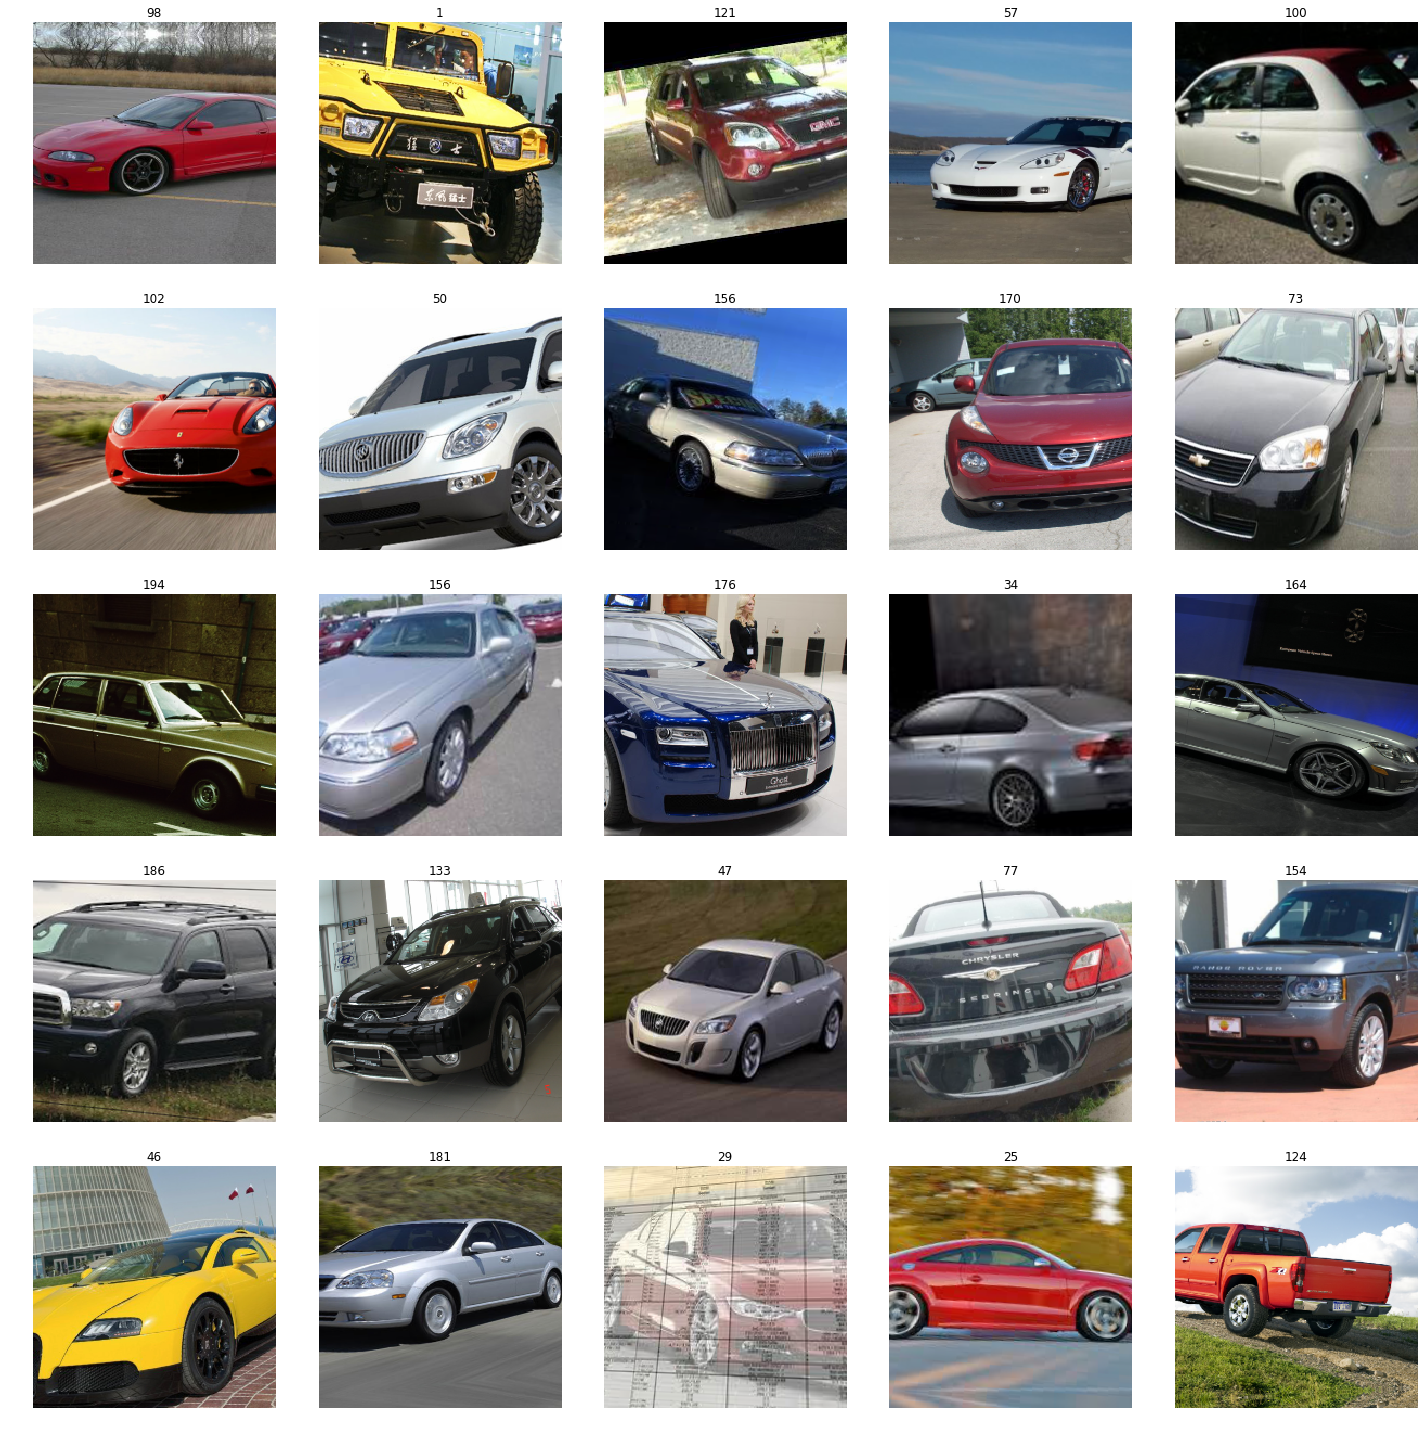

In [14]:
data.show_batch()

In [40]:
learn = cnn_learner(data, models.resnet152, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /home/jupyter/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:10<00:00, 23504560.46it/s]


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


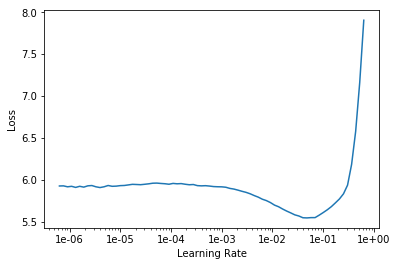

In [41]:
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(3,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.251592,4.095372,0.126866,01:00
1,2.995232,2.155342,0.433458,01:00
2,1.796454,1.437284,0.620025,01:01


In [44]:
learn.save('stage-1-resnet152')

In [45]:
learn.unfreeze()

In [46]:
learn.fit_one_cycle(2, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.338888,1.315610,0.656095,01:09
1,1.229190,1.265185,0.662935,01:07


In [47]:
learn.save('stage-2-resnet152')

In [12]:
## We decrease the batch size to not go cuda out of memory error
data = get_data(299, 16)
learn = cnn_learner(data, models.resnet152, metrics=accuracy)
learn.load('stage-2-resnet152')

/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py:315: ResourceWarning: unclosed file <_io.BufferedWriter name='/home/jupyter/aiforsea/data/models/tmpanyiy5fo'>
  torch.save(state, open(tmp_file, 'wb'))


Learner(data=ImageDataBunch;

Train: LabelList (6433 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
80,111,164,130,147
Path: data;

Valid: LabelList (1608 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
72,145,105,111,8
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_si

In [17]:
learn.data.batch_size = 16

In [23]:
learn.freeze()
learn.fit_one_cycle(1,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.350273,1.110958,0.707090,01:48


In [24]:
learn.unfreeze()
learn.fit_one_cycle(4,max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.190618,1.048634,0.726990,02:23
1,1.050005,0.942280,0.751244,03:11
2,0.935778,0.871535,0.767413,02:19
3,0.813684,0.866684,0.766169,02:19


In [25]:
learn.save('stage-4-resnet152')

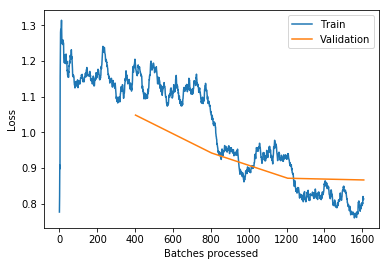

In [26]:
learn.recorder.plot_losses()

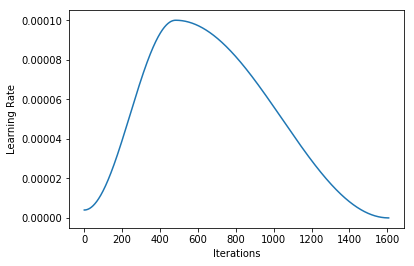

In [28]:
learn.recorder.plot_lr()

In [34]:
learn.export('exported-model.pkl',destroy=True)

/opt/anaconda3/lib/python3.7/site-packages/fastai/basic_train.py:242: ResourceWarning: unclosed file <_io.BufferedWriter name='data/exported-model.pkl'>
  try_save(state, self.path, file)


this Learner object self-destroyed - it still exists, but no longer usable
